# Getting Started

## Kernel functions

In [147]:
%load_ext autoreload
%autoreload 2

from lib.mesh import *
from lib.materials import*
from lib.assembly import StaticSolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## List of variables

In [148]:
# This section will load user inputs and set global variables
# Not implemented yet
# Go to user inputs for desired test case as a temporary solution

# Placeholder
# Need to consider which variables are user inputs

# E4D files
# 1. file .inp
# 2. file .sig
# 3. file .cfg
# 4. file .inv (skip for sip)
# 5. file .out
# 6. file .srv

# Possible SIP files
# 1. file .inp (specifies run_mode: 1 for mesh generation; 2 for static solution; 3 for coupled solution)
# 2. file .hdf5 (stores mesh and material properties for domain equation and boundary equation)
# 3. file .cfg (will generate .poly for triangle; will be compatible with sphere/slab/membrane models)
# 4. file .out (specifies output options)
# 5. file .srv (specifies survey/external field options)

# print('='*80)
# %whos module
# print('='*80)
# %whos type
# print('='*80)
# %whos str
# print('='*80)
# %whos int
# print('='*80)
# %whos float
# print('='*80)
# %whos list
# print('='*80)
# %whos dict
# print('='*80)
# %whos ndarray matrix
# print('='*80)
# %whos function
%whos

Variable            Type               Data/Info
------------------------------------------------
Consts              type               <class 'lib.materials.Consts'>
Flags               type               <class 'lib.mesh.Flags'>
Geometry            type               <class 'lib.mesh.Geometry'>
Mesh                type               <class 'lib.mesh.Mesh'>
PertubStern         type               <class 'lib.materials.PertubStern'>
Physics             type               <class 'lib.materials.Physics'>
StaticDirichlet     type               <class 'lib.materials.StaticDirichlet'>
StaticDomain        type               <class 'lib.materials.StaticDomain'>
StaticRobin         type               <class 'lib.materials.StaticRobin'>
StaticSolution      type               <class 'lib.assembly.StaticSolution'>
Survey              type               <class 'lib.materials.Survey'>
assemble_Ke2d       function           <function assemble_Ke2d at 0x7f2508cdfd30>
assemble_Ks2d       function     

# Example 1

## User inputs

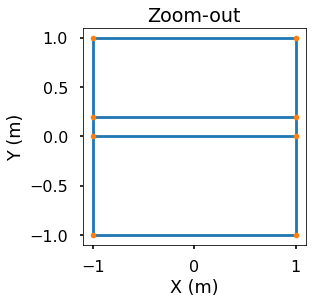

In [149]:
#modify user inputs in this block only
mesh_prefix = 'slab_2d'
triangle_path = 'triangle'

slab_geom = Geometry(
    shape = 'slab', #shape of the geometry
    radius_air = 1.0, #radius of air
    height_air = 1.0, #height of air
    radius_water = 1.0, #radius of water
    height_water = 0.2, #height of water
    radius_solid = 1.0, #radius of solid
    height_solid = 1.0, #height of solid
    axis_symmetry = 'None', #X, or Y, or None
    )

slab_phys = Physics(
    c_ion = [1.0,1.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-9, #ion mobility in solid [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C]
    temperature = 293.0, #ambient temperature [K]
    is_solid_metal = False, #True if solid is metal otherwise false
    )

slab_srv = Survey(
    mode = [0], #run mode 0 for static; 1 for peturbation
    ratio = [0.0], #ratio of sigma_stern to sigma_solid [SI]
    freq = [0.0], #frequency used for perturbation solution [Hz]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 0.0, #voltage on equipotential surface
    )

## Properties setup

Reading slab_2d.1.node
Reading slab_2d.1.ele
Reading slab_2d.1.edge

THE NUMBER OF NODES IS: 7171
THE NUMBER OF ELEMENTS IS: 14213
THE NUMBER OF EDGES IS: 21383

node_flags [ 0  1  2 11 12 13 14]
elem_flags [1 2 3]
edge_flags [ 0  1  2 11 12 13 14]



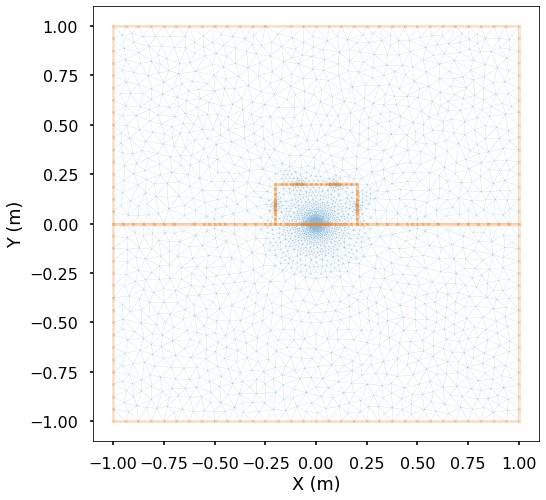

Computing shape functions of triangular elements
This will take a minute
Time elapsed  0.31915950775146484 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.037314653396606445 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  1.1991899013519287 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.26456761360168457 sec



In [174]:
slab_mesh = Mesh(
    mesh_prefix = mesh_prefix,
    triangle_path = triangle_path,
    build_mesh = False,
    axis_symmetry = slab_geom.axis_symmetry,
    cpts = slab_geom.cpts,
    segs = slab_geom.segs,
    holes = slab_geom.holes,
    zones = slab_geom.zones,
    )

domain_stat = StaticDomain(slab_mesh,slab_phys,slab_srv)
robin_stat = StaticRobin(slab_mesh,slab_phys,slab_srv)
dirichlet_stat = StaticDirichlet(slab_mesh,slab_phys,slab_srv)

In [175]:
print(domain_stat.f_n.shape)

(7171, 1)


## Static solution

(7171,)
(7171, 1)
Assembling the system of equations for triangular elements
This will take a while
Source
[[3.01702342]
 [2.9178999 ]
 [2.78155931]]
ind
[0 1 2 3 4 5 6 7 8]
[0 1 2]
Check5/2
[[ 0.5601631  -0.25507391 -0.30508919]
 [-0.25507391  0.56244815 -0.30737424]
 [-0.30508919 -0.30737424  0.61246343]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[0.00103738 0.00102861 0.00101656]
Time elapsed  1.7589032649993896 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  0.03375673294067383 sec

Calling sparse linear system solver
Time elapsed  0.039884328842163086 sec

Computing fields and gradients in elements
Time elapsed  0.002552509307861328 sec



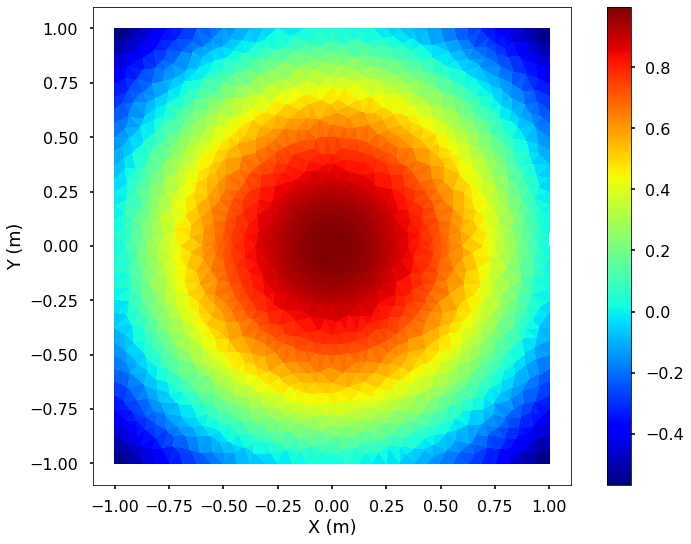

In [188]:
slab_stat = StaticSolution(slab_mesh,domain_stat,robin_stat,dirichlet_stat)
slab_mesh.tripcolor(slab_stat.sol)

In [ ]:
run_simulation(model,survey)

## Pertubation solution